%md
##  Ride Share Analytics

Setup Spark Session

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, sum as spark_sum, avg as spark_avg, row_number
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("RideShareAnalytics").getOrCreate()


**Tasks for Participants**
1. Load all three files into separate DataFrames.
2. Inspect schemas and verify correct data types.
3. Identify rides with missing drivers (notice one ride has no match).
4. Join rides ↔ drivers to include city , experience_years , rating .
5. Add a column earnings_per_km = price / distance_km .
6. Calculate total revenue per city.
7. Determine average rating by city.
8. Find the top earning driver in each city using a window function.
9. Identify drivers with no rides (Left Join).
10. Combine the feedback dataset to mark ride performance.
11. Count rides by feedback category (Excellent/Good/Average).
12. Using SQL view, find cities with highest average ride price.
13. Save final combined DataFrame as rides_summary.csv in DBFS.
14. Plot total earnings per city as a bar chart.

In [0]:
drivers_df = spark.read.csv("/FileStore/tables/drivers.csv", header=True, inferSchema=True)
rides_df   = spark.read.csv("/FileStore/tables/rides.csv",   header=True, inferSchema=True)
feedback_df= spark.read.csv("/FileStore/tables/feedback.csv",header=True, inferSchema=True)

display(drivers_df)
display(rides_df)
display(feedback_df)


driver_id,driver_name,city,experience_years,rating
1,Arun Kumar,Bangalore,4,4.6
2,Pooja Rao,Chennai,2,4.3
3,Imran Sheikh,Delhi,6,4.8
4,Nisha Patel,Hyderabad,1,4.0
5,Rajesh Naik,Mumbai,8,4.9
6,Sneha Menon,Bangalore,3,4.4


ride_id,driver_id,distance_km,price,ride_date
1001,1,10,250,2024-02-01
1002,2,7,180,2024-02-03
1003,3,15,500,2024-02-05
1004,4,5,120,2024-02-08
1005,1,12,300,2024-02-10
1006,5,20,800,2024-02-15
1007,6,9,230,2024-02-20
1008,7,11,270,2024-02-22


ride_id,customer_feedback
1001,Excellent
1002,Good
1003,Excellent
1004,Average
1005,Good
1006,Excellent
1007,Average
1008,Good


In [0]:
drivers_df.printSchema()
rides_df.printSchema()
feedback_df.printSchema()


root
 |-- driver_id: integer (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- experience_years: integer (nullable = true)
 |-- rating: double (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- distance_km: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- ride_date: date (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- customer_feedback: string (nullable = true)



In [0]:
missing_drivers = rides_df.join(drivers_df, "driver_id", "left_anti")
display(missing_drivers)


driver_id,ride_id,distance_km,price,ride_date
7,1008,11,270,2024-02-22


In [0]:
rides_joined_df = rides_df.join(drivers_df, "driver_id", "left")
display(rides_joined_df)


driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating
1,1001,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6
2,1002,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3
3,1003,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8
4,1004,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0
1,1005,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6
5,1006,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9
6,1007,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4
7,1008,11,270,2024-02-22,null,null,null,null


In [0]:
rides_joined_df = rides_joined_df.withColumn(
    "earnings_per_km",
    round(col("price") / col("distance_km"), 2)
)
display(rides_joined_df)


driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km
1,1001,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0
2,1002,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3,25.71
3,1003,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.33
4,1004,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0
1,1005,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0
5,1006,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0
6,1007,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.56
7,1008,11,270,2024-02-22,null,null,null,null,24.55


In [0]:
revenue_per_city = rides_joined_df.groupBy("city") \
    .agg(spark_sum("price").alias("total_revenue")) \
    .orderBy(col("total_revenue").desc())

display(revenue_per_city)


city,total_revenue
Mumbai,800
Bangalore,780
Delhi,500
null,270
Chennai,180
Hyderabad,120


In [0]:
avg_rating_city = drivers_df.groupBy("city") \
    .agg(round(spark_avg("rating"), 2).alias("avg_rating")) \
    .orderBy(col("avg_rating").desc())

display(avg_rating_city)


city,avg_rating
Mumbai,4.9
Delhi,4.8
Bangalore,4.5
Chennai,4.3
Hyderabad,4.0


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

driver_earnings = rides_joined_df.groupBy("driver_id", "driver_name", "city") \
    .agg(spark_sum("price").alias("total_earnings"))

window_spec = Window.partitionBy("city").orderBy(F.desc("total_earnings"))
top_driver_city = driver_earnings.withColumn("rank", F.row_number().over(window_spec)) \
                                .filter(col("rank") == 1)

display(top_driver_city)


driver_id,driver_name,city,total_earnings,rank
7,null,null,270,1
1,Arun Kumar,Bangalore,550,1
2,Pooja Rao,Chennai,180,1
3,Imran Sheikh,Delhi,500,1
4,Nisha Patel,Hyderabad,120,1
5,Rajesh Naik,Mumbai,800,1


In [0]:
drivers_no_rides = drivers_df.join(rides_df, "driver_id", "left_anti")
display(drivers_no_rides)


driver_id,driver_name,city,experience_years,rating


In [0]:
rides_feedback_df = rides_joined_df.join(feedback_df, "ride_id", "left")
display(rides_feedback_df.select("ride_id","driver_name","city","price","customer_feedback"))


ride_id,driver_name,city,price,customer_feedback
1005,Arun Kumar,Bangalore,300,Good
1004,Nisha Patel,Hyderabad,120,Average
1007,Sneha Menon,Bangalore,230,Average
1003,Imran Sheikh,Delhi,500,Excellent
1002,Pooja Rao,Chennai,180,Good
1006,Rajesh Naik,Mumbai,800,Excellent
1001,Arun Kumar,Bangalore,250,Excellent
1008,null,null,270,Good


In [0]:
feedback_count = rides_feedback_df.groupBy("customer_feedback").count()
display(feedback_count)


customer_feedback,count
Average,2
Excellent,3
Good,3


In [0]:
rides_feedback_df.createOrReplaceTempView("rides_view")

result_sql = spark.sql("""
SELECT city, ROUND(AVG(price),2) AS avg_ride_price
FROM rides_view
GROUP BY city
ORDER BY avg_ride_price DESC
""")

display(result_sql)


city,avg_ride_price
Mumbai,800.0
Delhi,500.0
null,270.0
Bangalore,260.0
Chennai,180.0
Hyderabad,120.0


In [0]:
output_path = "/FileStore/tables/rides_summary"

rides_feedback_df.write.mode("overwrite").option("header", True).csv(output_path)
display(dbutils.fs.ls(output_path))


path,name,size,modificationTime
dbfs:/FileStore/tables/rides_summary/_SUCCESS,_SUCCESS,0,1759835119000
dbfs:/FileStore/tables/rides_summary/_committed_4715323903053722924,_committed_4715323903053722924,113,1759835119000
dbfs:/FileStore/tables/rides_summary/_started_4715323903053722924,_started_4715323903053722924,0,1759835118000
dbfs:/FileStore/tables/rides_summary/part-00000-tid-4715323903053722924-d020d762-28af-4b9e-a650-9dab9ebf2d47-163-1-c000.csv,part-00000-tid-4715323903053722924-d020d762-28af-4b9e-a650-9dab9ebf2d47-163-1-c000.csv,611,1759835119000


In [0]:
summary_df = spark.read.csv(output_path, header=True, inferSchema=True)
display(summary_df)


ride_id,driver_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km,customer_feedback
1001,1,10,250,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0,Excellent
1002,2,7,180,2024-02-03,Pooja Rao,Chennai,2,4.3,25.71,Good
1003,3,15,500,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.33,Excellent
1004,4,5,120,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0,Average
1005,1,12,300,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0,Good
1006,5,20,800,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0,Excellent
1007,6,9,230,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.56,Average
1008,7,11,270,2024-02-22,null,null,null,null,24.55,Good


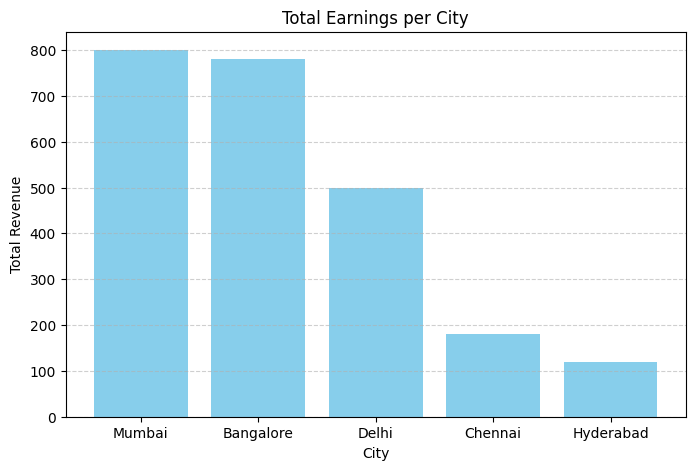

In [0]:
import matplotlib.pyplot as plt

city_pd = revenue_per_city.toPandas().dropna(subset=['city', 'total_revenue'])

plt.figure(figsize=(8,5))
plt.bar(city_pd["city"], city_pd["total_revenue"], color="skyblue")
plt.title("Total Earnings per City")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
